In [1]:
# conda environment (project)
# /home/student/.conda/envs/project/bin/python 
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os, gc
import torch

from transformers import set_seed
from datasets import load_dataset
from evaluate import *
from arc.arc import ARCSolver

from datasets import Dataset
from utils import render_grid

In [3]:
# prepare the test dataset
data_path = "dataset"
dataset, task_list = load_data(data_path)
df300 = sample_data(dataset, task_list, n_row=30000) 
df300.head(5) 

Imported 300 different tasks in the dataset.
# of samples in a task: min(82), Q1(1000), Q2(1000), Q3(1000), max(1000), mean(897.7)


,task,train,test_input,test_output,test
0,239be575,"[{'input': [[0, 0, 6, 6, 2, 0, 0], [2, 0, 6, 6...","[{'input': [[0, 5, 5, 3, 3, 3, 0], [0, 5, 5, 0...",[[[0]]],"[{'input': [[0, 5, 5, 3, 3, 3, 0], [0, 5, 5, 0..."
1,4258a5f9,"[{'input': [[3, 3, 3, 3], [3, 3, 3, 3], [3, 3,...","[{'input': [[6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 2...","[[[6, 6, 6, 1, 1, 1], [1, 1, 1, 1, 2, 1], [1, ...","[{'input': [[6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 2..."
2,1caeab9d,"[{'input': [[6, 6, 6, 6, 6, 6, 6], [6, 6, 8, 8...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4..."
3,623ea044,"[{'input': [[3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3...","[{'input': [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], ...","[[[6, 8, 6, 6, 6], [6, 6, 8, 6, 8], [6, 6, 6, ...","[{'input': [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], ..."
4,e9afcf9a,"[{'input': [[4, 4, 4, 4, 4], [6, 6, 6, 6, 6], ...","[{'input': [[5, 5, 5, 5, 5, 5, 5, 5, 5], [7, 7...","[[[5, 7, 5, 7, 5, 7, 5, 7, 5], [7, 0, 7, 0, 7,...","[{'input': [[5, 5, 5, 5, 5, 5, 5, 5, 5], [7, 7..."


In [4]:
# prepare samples for each task
task_samples = []
for t in range(300):
    df = sample_data(dataset, task_list, n_row=1000, indices=[t])
    task_samples.append(df)

In [5]:
# Visualize a task (EDA)
task_indices = [11] # select which task you want to examine
n_sample = 1
for task_idx in task_indices:
    print(task_idx)
    for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(n_sample)):
        for case in data['train']:
            print("==================================================")
            print("Example input")
            render_grid(case['input'])
            print("Example output")
            render_grid(case['output'])
            break
        print("==================================================")
        print("Example test input")
        render_grid(data['test'][0]['input'])
        print("Example test output")
        render_grid(data['test'][0]['output'])
    print("==================================================")

11
Example input


                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 4, 4, 1]
                    [1, 1, 1, 1, 4, 1, 4, 4, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]

Example output


                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [1, 1, 1, 1, 1, 1, 4, 4, 1]
                    [1, 1, 1, 1, 4, 9, 4, 4, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]
                    [1, 1, 1, 1, 4, 1, 1, 1, 1]

Example test input


                      [0, 0, 0, 3, 3, 3, 3, 0, 0, 3]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 3]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 3]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 3]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 0]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Example test output


                      [0, 0, 0, 3, 3, 3, 3, 0, 0, 3]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
                      [3, 3, 3, 3, 3, 3, 9, 9, 9, 3]
                      [3, 3, 3, 3, 3, 3, 9, 9, 9, 3]
                      [3, 3, 3, 3, 3, 3, 9, 9, 9, 3]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 0]
                      [3, 3, 3, 3, 3, 3, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [5]:
simple_tasks = []
hard_tasks = []
for task_idx in range(300):
    check = True
    for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(3)):
        for case in data['train']:
            wi, hi = len(case['input'][0]), len(case['input'])
            wo, ho = len(case['output'][0]), len(case['output'])
            if (wi!=wo) or (hi!=ho): check = False
        case = data['test'][0]
        wi, hi = len(case['input'][0]), len(case['input'])
        wo, ho = len(case['output'][0]), len(case['output'])
        if (wi!=wo) or (hi!=ho): check = False
    if check: simple_tasks.append(task_idx)
    else: hard_tasks.append(task_idx)
print(simple_tasks)

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 142, 143, 144, 145, 146, 148, 149, 150, 154, 157, 161, 163, 168, 169, 172, 175, 178, 179, 180, 182, 183, 184, 187, 189, 190, 193, 195, 196, 197, 198, 199, 200, 203, 207, 210, 211, 212, 213, 216, 217, 219, 221, 223, 226, 227, 228, 230, 233, 234, 238, 242, 243, 245, 252, 255, 259, 261, 262, 266, 276, 277, 278, 281, 282, 287, 288, 289, 291, 292, 293, 294]


In [6]:
set_seed(1234567890)
token = os.environ.get("HF_TOKEN", None)
solver = ARCSolver(model_id="Qwen/Qwen3-1.7B", hf_token=token)

In [9]:
# solver.prepare_train()
n_train = len(hard_tasks)*1000
n_eval = 500
dfsimple = sample_data(dataset, task_list, n_row=n_train+n_eval, indices=simple_tasks, random=56)
dfhard = sample_data(dataset, task_list, n_row=n_train+n_eval, indices=hard_tasks, random=56)
train_dataset = Dataset.from_pandas(dfsimple).select(range(n_train))
# solver.train(train_dataset)

In [8]:
n_eval = 100
solver.prepare_evaluation(select_adapter="20250702_220556") # make sure you set the right model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 15.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 10.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 10.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 35.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 10.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 15.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 40.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 40.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 45.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 0.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 5.00


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation score: 20.00


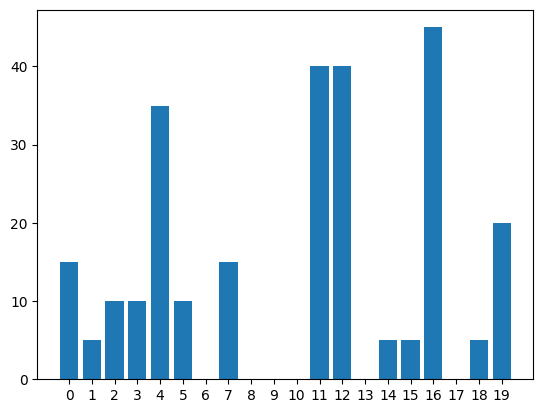

In [14]:
# evaluate our model (eval set)
scores = []
n_eval = 20
scores_task = []
for task in range(20):
    eval_dataset = Dataset.from_pandas(task_samples[task]).select(range(n_eval))
    for eval_data in tqdm(eval_dataset):
        # print("============================================")
        # print("Test input")
        # render_grid(eval_data["test"][0]['input'])

        # print("Predict output")
        preds = solver.predict(eval_data)
        # if preds is not None: render_grid(preds)

        # print("Test output")
        # render_grid(eval_data["test"][0]['output'])
        # print("============================================")
        if preds is None: s = 0
        else: s = check_match(preds, eval_data["test"][0]["output"])
        scores.append(s)
    score = np.array(scores).mean() * 100
    scores_task.append(score)
    print(f"Evaluation score: {score:.2f}", flush=True)
    scores = []

from matplotlib import pyplot as plt
x = np.arange(20)
plt.bar(x, scores_task)
plt.xticks(x, list(range(20)))
plt.show()